### Ejercicio
### K-nearest neighbors
<p>1) Usando numpy.random.multivariate_normal, generar 2x250 muestras aleatorias de dos normales bivariadas (cercanas pero diferentes) y graficarlas con colores diferentes.</p>
<p>2) Concatenar ambas muestras y generar un vector de etiquetas adecuado (Obtenga una matriz X de 500x2 con las muestras, y un vector Y de 500 de largo con las etiquetas).</p>
<p>3) Utilizar el clasificador KNN de sklearn con este conjunto, como en el ejemplo visto en clase (KNN.ipnb de esta carpeta).</p>
<p>4) Escribir una funcion KNN(X,Y,x0,y0,k) que dadas las muestras X con etiquetas Y y una nueva muestra (x0,y0) encuentre los k-vecinos más cercanos, y devuelva la etiqueta correspondiente definida como la de mayor ocurrencia entre los k-vecinos más cercanos. Elegir un criterio para definir en caso de empate.</p>
<p>5) Escriba una nueva versión de la funcion anterior que en lugar de una etiqueta devuelva un vector de probabilidades (ordenado de mayor a menor) definido a partir de la frecuencia ocurrencia de etiquetas entre los k-vecinos más cercanos.</p>



In [510]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
%matplotlib inline

1) Usando numpy.random.multivariate_normal, generar 2x250 muestras aleatorias de dos normales bivariadas (cercanas pero diferentes) y graficarlas con colores diferentes.

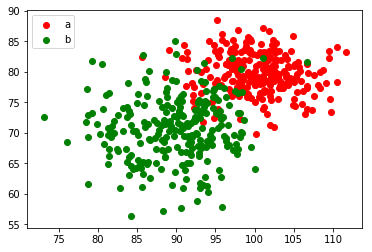

In [586]:
mean1 = [100, 80]
mean2 = [90, 70]
cov1 = [[20, 0], [0, 10]]
cov2 = [[30, 0], [0, 25]]
a = np.random.multivariate_normal(mean1, cov1, 250)
b = np.random.multivariate_normal(mean2, cov2, 250)
plt.scatter(a[:,0], a[:,1], c = 'r')
plt.scatter(b[:,0], b[:,1], c = 'g')
plt.legend(['a', 'b'])

2) Concatenar ambas muestras y generar un vector de etiquetas adecuado (Obtenga una matriz X de 500x2 con las muestras, y un vector Y de 500 de largo con las etiquetas).

In [587]:
X = np.concatenate((a,b))

#Creo vector Y co ndatos binarios 
Y = np.full(500, [1] * 250 + [2] * 250)

3) Utilizar el clasificador KNN de sklearn con este conjunto, como en el ejemplo visto en clase (KNN.ipnb de esta carpeta).

In [588]:
num_neighbors=3
knn = KNeighborsClassifier(n_neighbors=num_neighbors)
knn.fit(X, Y)
y_pred = knn.predict(X)
print('Tasa de prediccion: {0}'.format(np.mean(Y==y_pred)))

Tasa de prediccion: 0.938


Hay que plotear los limites de decision. Para eso, voy a asignar un color a cada punto del mesh [x_min, x_max]x[y_min, y_max]


In [589]:
step_size=0.2
x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Pongo el resultado en un color plot

Text(0.5,1,'Clasificación con KNN, con k=3')

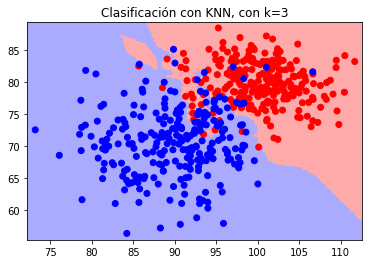

In [590]:
Z = Z.reshape(xx.shape)

#Creo el mapa de colores
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

#Ploteo tambien los puntos

plt.scatter(X[:,0], X[:,1], c=Y, cmap=cmap_bold)
plt.title('Clasificación con KNN, con k={0}'.format(num_neighbors))


4) Escribir una funcion KNN(X,Y,x0,y0,k) que dadas las muestras X con etiquetas Y y una nueva muestra (x0,y0) encuentre los k-vecinos más cercanos, y devuelva la etiqueta correspondiente definida como la de mayor ocurrencia entre los k-vecinos más cercanos. Elegir un criterio para definir en caso de empate.

In [605]:
def KNN(X, Y, x0, y0, k):
    
    neighbors = pd.DataFrame()
    dists=((X[:,0]-x0)**2 + (X[:,1]-y0)**2)**0.5
    dists_k = list()

    for i in range(k):
        neighbors = neighbors.append(pd.DataFrame(np.c_[X[dists.argmin(),0], X[dists.argmin(),1], Y[dists.argmin()]]))
        dists_k.append(dists.min())
        dists=np.delete(dists, dists.argmin())
    
    neighbors.columns=['x', 'y', 'label']
    neighbors=neighbors.reset_index(drop=True)
    neighbors['dists']=pd.Series(dists_k)
    
    cant_labels = dict()

    for lab in neighbors.label.unique():
        cant_labels.update({lab:neighbors.where(neighbors.label == lab).dropna().label.size})
    
    #Busco si hay un empate, creo una lista con las label que tienen la mayor aparicion
    nearest_labels=list()

    for key in cant_labels.keys():
        if cant_labels[key] == np.amax(list(cant_labels.values())):
            nearest_labels.append(key)
   
    #Este es el caso de si hay un empate, me quedo con los vecinos cuya 
    #distancia total (la suma de la distancia de cada vecino) es la menor
    if len(nearest_labels) >1:
        dist_tot=dict()
        
        for lab in nearest_labels:
            dist_tot.update({lab : neighbors.where(neighbors.label == lab).dropna().dists.sum()})
    
        min_dist = np.amin(list(dist_tot.values()))
    
        for key in dist_tot.keys():
            if dist_tot[key] == min_dist:
                nearest_neighbors_label = key
    
        return nearest_neighbors_label
    
    else:
        return nearest_labels[0]

Pruebo la funcion con algun punto (x0, y0)

In [606]:
x0=95
y0=75
k=5
print('Prediccion de etiqueta para el punto ({0}, {1}) con k={3} => etiqueta={2} '.format(x0, y0, KNN(X, Y, x0, y0, k), k))

Prediccion de etiqueta para el punto (95, 75) con k=5 => etiqueta=2.0 


5) Escriba una nueva versión de la funcion anterior que en lugar de una etiqueta devuelva un vector de probabilidades (ordenado de mayor a menor) definido a partir de la frecuencia ocurrencia de etiquetas entre los k-vecinos más cercanos.

In [626]:
def KNN_prob(X, Y, x0, y0, k):
    
    neighbors = pd.DataFrame()
    dists=((X[:,0]-x0)**2 + (X[:,1]-y0)**2)**0.5
    dists_k = list()

    for i in range(k):
        neighbors = neighbors.append(pd.DataFrame(np.c_[X[dists.argmin(),0], X[dists.argmin(),1], Y[dists.argmin()]]))
        dists_k.append(dists.min())
        dists=np.delete(dists, dists.argmin())
    
    neighbors.columns=['x', 'y', 'label']
    neighbors=neighbors.reset_index(drop=True)
    neighbors['dists']=pd.Series(dists_k)
    
    cant_labels = dict()

    for lab in neighbors.label.unique():
        cant_labels.update({lab:neighbors.where(neighbors.label == lab).dropna().label.size})
    
    #Armando el vector de probabilidades.
    prob_list = list()
   
    i=0
    for elem in list(cant_labels.keys()):
        prob_list.append((list(cant_labels.keys())[i],list(cant_labels.values())[i]/k))
        i+=1
    
    prob_list = sorted(prob_list, key=lambda tup: tup[1], reverse=True)
    prob_array = np.array(prob_list)
    
    return prob_array

Pruebo con un valor (x0, y0)

In [637]:
x0=95
y0=75
k=5

for tupl in KNN_prob(X, Y, x0, y0, k):
    print('La probabilidad de que ({0}, {1}) sea categoria {2} es {3}'.format(x0, y0, tupl[0], tupl[1]))
    

La probabilidad de que (95, 75) sea categoria 2.0 es 0.8
La probabilidad de que (95, 75) sea categoria 1.0 es 0.2
